<a href="https://colab.research.google.com/github/Sungrebe/Smart-Bird-Feeder/blob/main/cc_backyard_bird_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# install astrapy and sentence_transformers (run this every time the runtime restarts)
!pip install astrapy
!pip install transformers

import os
from PIL import Image
from matplotlib import pyplot as plt
from astrapy import DataAPIClient
from transformers import CLIPProcessor, CLIPModel
from google.colab import drive, userdata, files

# load database and image collection

client = DataAPIClient(userdata.get("ASTRA_DB_APPLICATION_TOKEN"))
db = client.get_database(userdata.get("ASTRA_DB_API_ENDPOINT"))
col = db.get_collection("cc_backyard_birds")

# load CLIP model (Vit-B-32)

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

In [ ]:
# Helper method for the model to process image inputs
def process_image(image_path):
  input = processor(
    images=Image.open(image_path),
    return_tensors="pt"
  )
  return model.get_image_features(**input).flatten()

# Hash table with select bird species (only 11 for testing purposes)
# and their image folders from the nabirds dataset
# in the final version we will have at least 100 species
species = {
    "Mourning Dove": ["0529"],
    "Red-bellied Woodpecker": ["0553"],
    "Blue Jay": ["0950"],
    "Black-capped Chickadee": ["0812"],
    "Tufted Titmouse": ["0819"],
    "European Starling": ["0748", "0856", "1005"],
    "American Robin": ["0753", "0960"],
    "House Finch": ["0790", "0997"],
    "American Goldfinch": ["0794", "1001"],
    "Common Grackle": ["0912"],
    "Northern Cardinal": ["0772", "0979"],
}

# load cc_backyard_birds images into dataset

drive.mount('/content/drive')
nabirds_dir = "/content/drive/MyDrive/nabirds/"

for species_name, species_folders in species.items():
  for folder in species_folders:
    for img_file in os.listdir(nabirds_dir + folder):
      # convert each image into a vector representation using CLIP model
      img_vector = process_image(nabirds_dir + folder + "/" + img_file)

      col.insert_one({
          "text": species_name,
          "$vector": img_vector.tolist(),
      })

Saving northern_cardinal.jpg to northern_cardinal.jpg


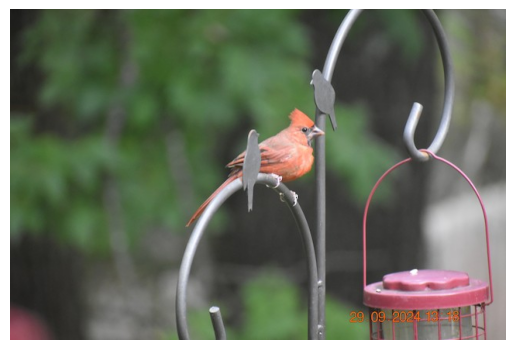

{'_id': '2d6ffc69-42d0-4560-affc-6942d0756091', 'text': 'Northern Cardinal', '$similarity': 0.9386964}
{'_id': '642e05e6-c028-423b-ae05-e6c028523bf5', 'text': 'Northern Cardinal', '$similarity': 0.9354377}
{'_id': '9f9df6c8-d203-44c2-9df6-c8d20374c295', 'text': 'Northern Cardinal', '$similarity': 0.9330345}
{'_id': 'c262cf55-8e8e-41cd-a2cf-558e8ed1cdc9', 'text': 'House Finch', '$similarity': 0.9326705}
{'_id': '4181230c-2788-4df1-8123-0c2788adf149', 'text': 'Northern Cardinal', '$similarity': 0.9313849}
{'_id': 'f67512a8-d70b-4d2e-b512-a8d70b4d2eae', 'text': 'Northern Cardinal', '$similarity': 0.93057036}
{'_id': '605a3710-db02-4abc-9a37-10db021abcf7', 'text': 'Northern Cardinal', '$similarity': 0.9282125}
{'_id': 'd9c4c0a5-af3f-4086-84c0-a5af3f508629', 'text': 'Black-capped Chickadee', '$similarity': 0.92480165}
{'_id': '21183a93-45a8-4bd2-983a-9345a81bd2f3', 'text': 'House Finch', '$similarity': 0.9241425}
{'_id': '8d376699-0b39-4a6c-b766-990b39ea6cf4', 'text': 'House Finch', '$simil

In [40]:
# method for searching database
# returns top 15 most similar images given a specific image
async def search_img(image_path):
  searching_vector = process_image(image_path).tolist()
  most_similar_imgs = col.find(
      {},
      sort={"$vector": searching_vector},
      limit=15,
      include_similarity=True,
  )

  return most_similar_imgs

# demo code, loads a user inputted image and classifies it using the search_img method

images = files.upload()
input_path = next(iter(images))

plt.imshow(Image.open(input_path))
plt.axis("off")
plt.show()

results = await search_img(input_path)

for result in results:
  print(result)